# Modelo de Classificação de Intenções com CNN e LSTM

Este notebook implementa uma rede neural para classificar a intenção de um usuário (`intent`) em uma categoria de serviço (`service_name`) com base em uma frase de entrada.

A arquitetura do modelo combina:
- **Camadas Convolucionais (Conv1D)**: Para extrair características locais e n-gramas do texto.
- **Camadas Recorrentes (LSTM)**: Para entender o contexto e as dependências sequenciais nas características extraídas.

### 1. Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, 
                                      Bidirectional, Input, GlobalMaxPooling1D, 
                                      GlobalAveragePooling1D, Concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import re

### 2. Carregamento e Pré-processamento dos Dados

Carregamos o arquivo CSV, definimos o delimitador e separamos as colunas de entrada (`intent`) e de alvo (`service_name`).

In [2]:
# O caminho para o CSV de TREINAMENTO é relativo à localização deste notebook
# csv_path_train = '../../../assets/intents_generated.csv'
csv_path_train = 'intents_generated_4.csv'

df_train = pd.read_csv(csv_path_train, delimiter=';')

# Remover linhas com valores ausentes
df_train.dropna(subset=['intent', 'service_name'], inplace=True)

# Definir textos (X) e rótulos (y) para o treino
intents_train = df_train['intent'].values
service_names_train = df_train['service_name'].values

print("Dados de Treinamento Carregados:")
df_train.head()

Dados de Treinamento Carregados:


,service_id,service_name,intent
0,1,Consulta Limite / Vencimento do cartão / Melho...,Quanto tem disponível para usar
1,1,Consulta Limite / Vencimento do cartão / Melho...,quando fecha minha fatura
2,1,Consulta Limite / Vencimento do cartão / Melho...,Quando vence meu cartão
3,1,Consulta Limite / Vencimento do cartão / Melho...,quando posso comprar
4,1,Consulta Limite / Vencimento do cartão / Melho...,vencimento da fatura


### 2.1. Normalização do Texto

Para melhorar a qualidade dos dados, vamos normalizar o texto removendo pontuações excessivas e convertendo para minúsculas.

In [3]:
# O caminho para o CSV de AVALIAÇÃO é relativo à localização deste notebook
csv_path_test = 'intents_pre_loaded.csv'

df_test = pd.read_csv(csv_path_test, delimiter=';')

# Remover linhas com valores ausentes
df_test.dropna(subset=['intent', 'service_name'], inplace=True)

# Definir textos (X) e rótulos (y) para o teste
intents_test = df_test['intent'].values
service_names_test = df_test['service_name'].values

print("\nDados de Avaliação Carregados:")
df_test.head()


Dados de Avaliação Carregados:


,service_id,service_name,intent
0,1,Consulta Limite / Vencimento do cartão / Melho...,Quanto tem disponível para usar
1,1,Consulta Limite / Vencimento do cartão / Melho...,quando fecha minha fatura
2,1,Consulta Limite / Vencimento do cartão / Melho...,Quando vence meu cartão
3,1,Consulta Limite / Vencimento do cartão / Melho...,quando posso comprar
4,1,Consulta Limite / Vencimento do cartão / Melho...,vencimento da fatura


In [4]:
def normalize_text(text):
    """Normaliza o texto removendo pontuação excessiva e convertendo para minúsculas"""
    text = str(text).lower()
    # Remove múltiplos espaços
    text = re.sub(r'\s+', ' ', text)
    # Remove pontuação no final
    text = re.sub(r'[!?.,;:]+$', '', text)
    return text.strip()

# Aplicar normalização aos dados de treino e teste
intents_train = np.array([normalize_text(x) for x in intents_train])
intents_test = np.array([normalize_text(x) for x in intents_test])

print("Exemplos de textos normalizados:")
print(intents_train[:3])

Exemplos de textos normalizados:
['quanto tem disponível para usar' 'quando fecha minha fatura'
 'quando vence meu cartão']


### 3. Codificação dos Rótulos (Labels)

As redes neurais trabalham com números. Usamos o `LabelEncoder` para converter os nomes dos serviços (texto) em números inteiros.

In [5]:
# Combinar todos os rótulos para garantir que o LabelEncoder conheça todas as classes
all_service_names = np.concatenate([service_names_train, service_names_test])

label_encoder = LabelEncoder()
label_encoder.fit(all_service_names)

# Codificar os rótulos de treino e de teste
y_train_encoded = label_encoder.transform(service_names_train)
y_test_encoded = label_encoder.transform(service_names_test)

num_classes = len(label_encoder.classes_)

print(f"Número de classes de serviço: {num_classes}")
print(f"Exemplo de rótulo de treino codificado: {y_train_encoded[:5]}")
print(f"Exemplo de rótulo de teste codificado: {y_test_encoded[:5]}")

Número de classes de serviço: 16
Exemplo de rótulo de treino codificado: [2 2 2 2 2]
Exemplo de rótulo de teste codificado: [2 2 2 2 2]


### 4. Tokenização e Padding

O texto é convertido em sequências de números (`Tokenização`) e, em seguida, todas as sequências são padronizadas para ter o mesmo comprimento (`Padding`).

In [6]:
# Configurações aprimoradas
max_length = 40    # Aumentado para capturar frases mais longas
embedding_dim = 128 # Aumentado para vetores mais ricos
vocab_size_limit = 20000  # Limite para evitar overfitting

# Criar e treinar o tokenizer com os dados de TREINO
tokenizer = Tokenizer(num_words=vocab_size_limit, oov_token="<unk>")
tokenizer.fit_on_texts(intents_train)

# Tamanho real do vocabulário (limitado ou total)
vocab_size = min(len(tokenizer.word_index) + 1, vocab_size_limit)

# Converter textos de treino para sequências de inteiros
X_train_sequences = tokenizer.texts_to_sequences(intents_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')

# Converter textos de teste para sequências de inteiros
X_test_sequences = tokenizer.texts_to_sequences(intents_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Tamanho máximo das sequências: {max_length}")
print(f"Dimensão dos embeddings: {embedding_dim}")

Tamanho do vocabulário: 857
Tamanho máximo das sequências: 40
Dimensão dos embeddings: 128


### 6. Construção do Modelo Aprimorado (CNN + LSTM + Attention)

Modelo com arquitetura mais robusta:
- Múltiplas camadas convolucionais com diferentes tamanhos de kernel
- LSTM bidirecional com `return_sequences=True`
- Pooling global (Max + Average) para capturar características importantes
- Camadas densas com regularização

In [7]:
# Modelo funcional com arquitetura aprimorada
inp = Input(shape=(max_length,), dtype='int32')

# Camada de Embedding
emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(inp)

# Primeira camada convolucional
conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(emb)
conv1 = MaxPooling1D(pool_size=2)(conv1)

# Segunda camada convolucional
conv2 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)

# Dropout para regularização
drop1 = Dropout(0.1)(conv2)

# LSTM Bidirecional com return_sequences para pooling
lstm = Bidirectional(LSTM(128, return_sequences=True))(drop1)

# Combinar Global Max Pooling e Global Average Pooling
pool_max = GlobalMaxPooling1D()(lstm)
pool_avg = GlobalAveragePooling1D()(lstm)
concat = Concatenate()([pool_max, pool_avg])

# Camadas densas
dense1 = Dense(128, activation='relu')(concat)
drop2 = Dropout(0.1)(dense1)

# Camada de saída
out = Dense(num_classes, activation='softmax')(drop2)

# Criar o modelo
model = Model(inputs=inp, outputs=out)

# Compilar com taxa de aprendizado customizada
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 128)   │    109,696 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 40, 128)   │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 128)   │     82,048 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 128)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 256)   │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      2,064 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 571,920 (2.18 MB)

 Trainable params: 571,920 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

### 7. Treinamento do Modelo com Callbacks Avançados

Callbacks utilizados:
- **EarlyStopping**: Para interromper quando não houver melhora
- **ReduceLROnPlateau**: Reduz a taxa de aprendizado quando a perda estabiliza
- **ModelCheckpoint**: Salva o melhor modelo automaticamente

Também utilizamos **class weights** para balancear classes desbalanceadas.

In [8]:
# Calcular class weights para balancear classes desbalanceadas
classes = np.unique(y_train_encoded)
class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
class_weights = dict(zip(classes, class_weights_array))

print(f"Class weights calculados para {len(class_weights)} classes")

# Definir callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model_v4.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Treinar o modelo
history = model.fit(
    X_train_padded,
    y_train_encoded,
    validation_data=(X_test_padded, y_test_encoded),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights,
    verbose=2
)

Class weights calculados para 16 classes
Epoch 1/50

Epoch 1: val_loss improved from None to 2.66927, saving model to best_model_v4.h5


49/49 - 3s - 67ms/step - accuracy: 0.0836 - loss: 2.7029 - val_accuracy: 0.1075 - val_loss: 2.6693 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 2.66927 to 1.59625, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.3114 - loss: 1.9048 - val_accuracy: 0.3978 - val_loss: 1.5962 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 1.59625 to 1.11144, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.6114 - loss: 1.0774 - val_accuracy: 0.6022 - val_loss: 1.1114 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 1.11144 to 0.77412, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.7715 - loss: 0.6562 - val_accuracy: 0.7204 - val_loss: 0.7741 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss improved from 0.77412 to 0.59808, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.8481 - loss: 0.4737 - val_accuracy: 0.7527 - val_loss: 0.5981 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss improved from 0.59808 to 0.37438, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9075 - loss: 0.2984 - val_accuracy: 0.8710 - val_loss: 0.3744 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss improved from 0.37438 to 0.32137, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9330 - loss: 0.2106 - val_accuracy: 0.9140 - val_loss: 0.3214 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_loss improved from 0.32137 to 0.21820, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9509 - loss: 0.1615 - val_accuracy: 0.9570 - val_loss: 0.2182 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_loss improved from 0.21820 to 0.14046, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9592 - loss: 0.1288 - val_accuracy: 0.9677 - val_loss: 0.1405 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_loss did not improve from 0.14046
49/49 - 1s - 16ms/step - accuracy: 0.9738 - loss: 0.0867 - val_accuracy: 0.9677 - val_loss: 0.1563 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 0.14046
49/49 - 1s - 17ms/step - accuracy: 0.9738 - loss: 0.0765 - val_accuracy: 0.9570 - val_loss: 0.1413 - learning_rate: 1.0000e-03
Epoch 12/50

Epoch 12: val_loss improved from 0.14046 to 0.07003, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9789 - loss: 0.0615 - val_accuracy: 0.9785 - val_loss: 0.0700 - learning_rate: 5.0000e-04
Epoch 13/50

Epoch 13: val_loss improved from 0.07003 to 0.04054, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9866 - loss: 0.0399 - val_accuracy: 0.9892 - val_loss: 0.0405 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 14: val_loss did not improve from 0.04054
49/49 - 1s - 16ms/step - accuracy: 0.9911 - loss: 0.0279 - val_accuracy: 0.9892 - val_loss: 0.0423 - learning_rate: 5.0000e-04
Epoch 15/50

Epoch 15: val_loss improved from 0.04054 to 0.03451, saving model to best_model_v4.h5


49/49 - 1s - 19ms/step - accuracy: 0.9923 - loss: 0.0252 - val_accuracy: 0.9892 - val_loss: 0.0345 - learning_rate: 5.0000e-04
Epoch 16/50

Epoch 16: val_loss improved from 0.03451 to 0.01313, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9911 - loss: 0.0248 - val_accuracy: 1.0000 - val_loss: 0.0131 - learning_rate: 5.0000e-04
Epoch 17/50

Epoch 17: val_loss improved from 0.01313 to 0.00873, saving model to best_model_v4.h5


49/49 - 1s - 19ms/step - accuracy: 0.9936 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 18/50

Epoch 18: val_loss improved from 0.00873 to 0.00634, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9911 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 19/50

Epoch 19: val_loss did not improve from 0.00634
49/49 - 1s - 16ms/step - accuracy: 0.9949 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0085 - learning_rate: 5.0000e-04
Epoch 20/50

Epoch 20: val_loss improved from 0.00634 to 0.00423, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9974 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 21/50

Epoch 21: val_loss did not improve from 0.00423
49/49 - 1s - 17ms/step - accuracy: 0.9955 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0052 - learning_rate: 5.0000e-04
Epoch 22/50

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: val_loss did not improve from 0.00423
49/49 - 1s - 16ms/step - accuracy: 0.9962 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0046 - learning_rate: 5.0000e-04
Epoch 23/50

Epoch 23: val_loss improved from 0.00423 to 0.00411, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9974 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0041 - learning_rate: 2.5000e-04
Epoch 24/50

Epoch 24: val_loss improved from 0.00411 to 0.00317, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9974 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0032 - learning_rate: 2.5000e-04
Epoch 25/50

Epoch 25: val_loss did not improve from 0.00317
49/49 - 1s - 17ms/step - accuracy: 0.9962 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0034 - learning_rate: 2.5000e-04
Epoch 26/50

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 26: val_loss did not improve from 0.00317
49/49 - 1s - 16ms/step - accuracy: 0.9968 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0063 - learning_rate: 2.5000e-04
Epoch 27/50

Epoch 27: val_loss improved from 0.00317 to 0.00284, saving model to best_model_v4.h5


49/49 - 1s - 21ms/step - accuracy: 0.9955 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 1.2500e-04
Epoch 28/50

Epoch 28: val_loss improved from 0.00284 to 0.00277, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9974 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 1.2500e-04
Epoch 29/50

Epoch 29: val_loss improved from 0.00277 to 0.00265, saving model to best_model_v4.h5


49/49 - 1s - 20ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0026 - learning_rate: 1.2500e-04
Epoch 30/50

Epoch 30: val_loss improved from 0.00265 to 0.00256, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0026 - learning_rate: 1.2500e-04
Epoch 31/50

Epoch 31: val_loss improved from 0.00256 to 0.00237, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 1.2500e-04
Epoch 32/50

Epoch 32: val_loss improved from 0.00237 to 0.00208, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9962 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.2500e-04
Epoch 33/50

Epoch 33: val_loss improved from 0.00208 to 0.00202, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9968 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.2500e-04
Epoch 34/50

Epoch 34: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 34: val_loss did not improve from 0.00202
49/49 - 1s - 16ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 1.2500e-04
Epoch 35/50

Epoch 35: val_loss did not improve from 0.00202
49/49 - 1s - 16ms/step - accuracy: 0.9987 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 6.2500e-05
Epoch 36/50

Epoch 36: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 36: val_loss did not improve from 0.00202
49/49 - 1s - 15ms/step - accuracy: 0.9962 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 6.2500e-05
Epoch 37/50

Epoch 37: val_loss improved from 0.00202 to 0.00201, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9974 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 3.1250e-05
Epoch 38/50

Epoch 38: val_loss improved from 0.00201 to 0.00196, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9968 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 3.1250e-05
Epoch 39/50

Epoch 39: val_loss improved from 0.00196 to 0.00190, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9987 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 3.1250e-05
Epoch 40/50

Epoch 40: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 40: val_loss improved from 0.00190 to 0.00187, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9968 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 3.1250e-05
Epoch 41/50

Epoch 41: val_loss improved from 0.00187 to 0.00186, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9974 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.5625e-05
Epoch 42/50

Epoch 42: val_loss improved from 0.00186 to 0.00184, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9974 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.5625e-05
Epoch 43/50

Epoch 43: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 43: val_loss improved from 0.00184 to 0.00183, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9968 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.5625e-05
Epoch 44/50

Epoch 44: val_loss improved from 0.00183 to 0.00180, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9974 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 7.8125e-06
Epoch 45/50

Epoch 45: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 45: val_loss improved from 0.00180 to 0.00179, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9974 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 7.8125e-06
Epoch 46/50

Epoch 46: val_loss improved from 0.00179 to 0.00178, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9974 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 3.9063e-06
Epoch 47/50

Epoch 47: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 47: val_loss improved from 0.00178 to 0.00177, saving model to best_model_v4.h5


49/49 - 1s - 18ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 3.9063e-06
Epoch 48/50

Epoch 48: val_loss improved from 0.00177 to 0.00177, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.9531e-06
Epoch 49/50

Epoch 49: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 49: val_loss improved from 0.00177 to 0.00177, saving model to best_model_v4.h5


49/49 - 1s - 17ms/step - accuracy: 0.9974 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.9531e-06
Epoch 50/50

Epoch 50: val_loss improved from 0.00177 to 0.00177, saving model to best_model_v4.h5


49/49 - 1s - 16ms/step - accuracy: 0.9968 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 50.


### 8. Avaliação do Modelo

In [9]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"\nAcurácia no conjunto de teste: {accuracy:.4f}")


Acurácia no conjunto de teste: 1.0000


### 8.1. Matriz de Confusão

Para visualizar o desempenho do modelo em mais detalhes, geramos uma matriz de confusão. Ela mostra quais classes estão sendo confundidas umas com as outras.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Relatório de Classificação:

                                                               precision    recall  f1-score   support

                                           Atendimento humano       1.00      1.00      1.00         5
                                       Cancelamento de cartão       1.00      1.00      1.00         5
Consulta Limite / Vencimento do cartão / Melhor dia de compra       1.00      1.00      1.00         6
                                            Consulta do Saldo       1.00      1.00      1.00         6
                                        Desbloqueio de Cartão       1.00      1.00      1.00         6
                              Esqueceu senha / Troca de senha       1.00      1.00      1.00         6
                                          Pagamento de contas       1.00      1.00      1.00         5
                                                Perda e roubo       1.00      1.00      1.00         6
     

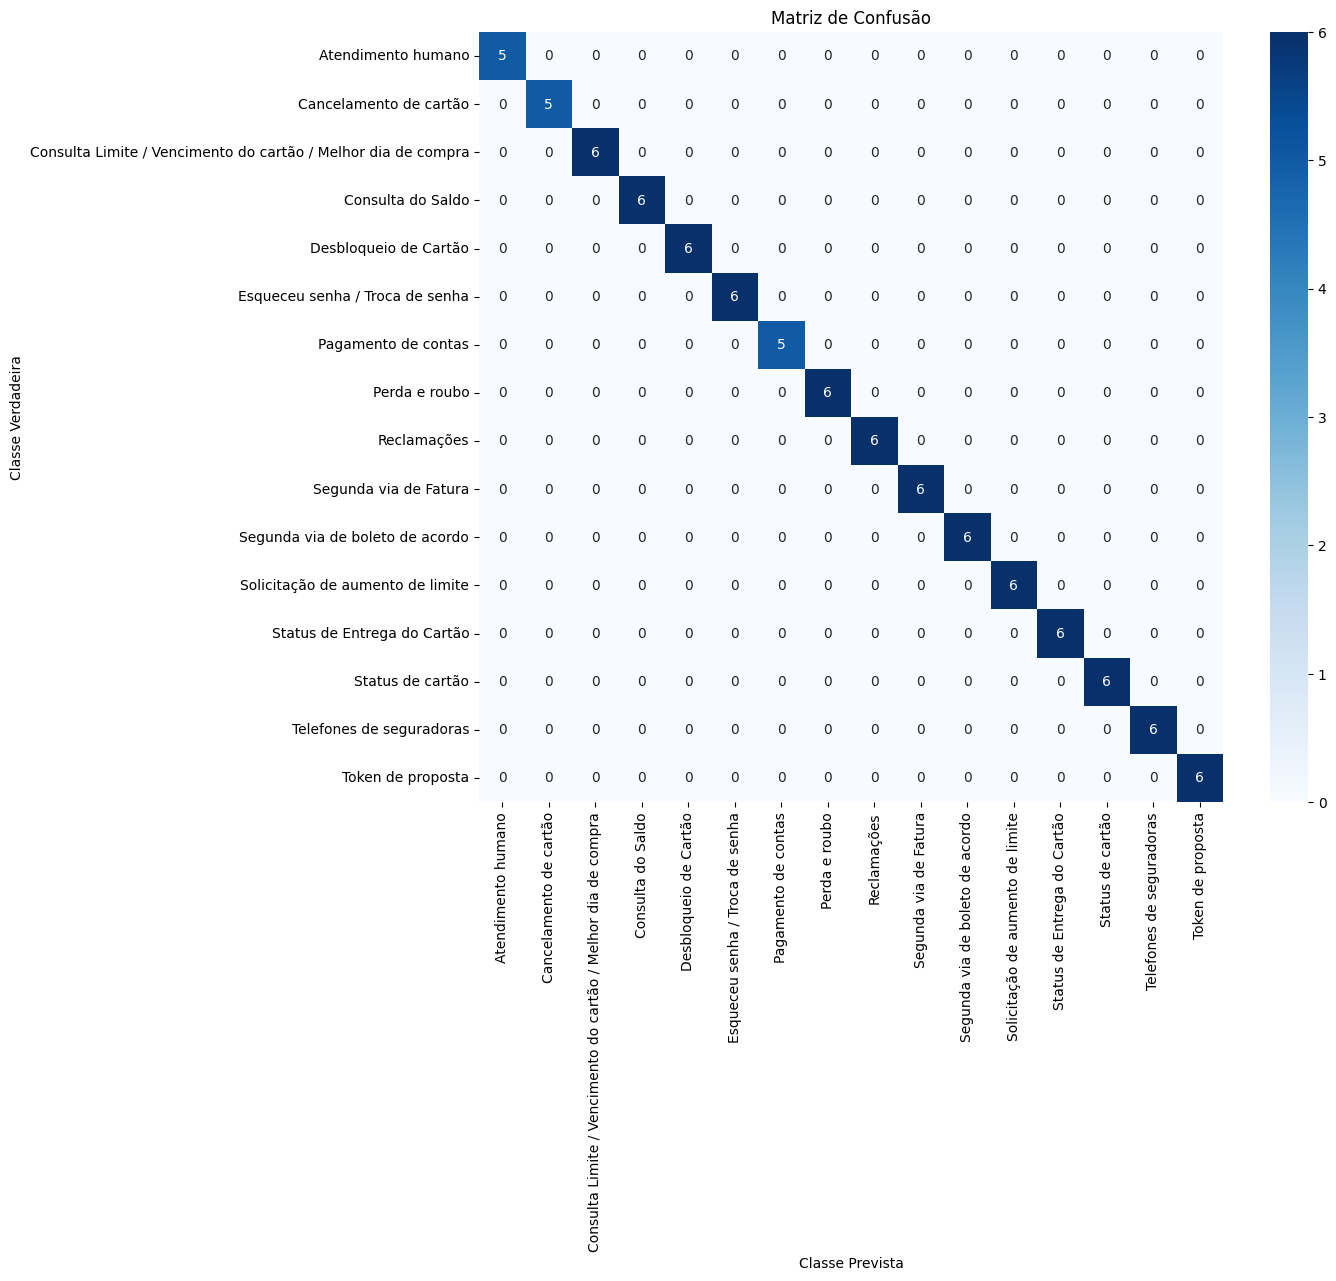

In [10]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nomes das classes para os eixos
class_names = label_encoder.classes_

# Imprimir o relatório de classificação
print("Relatório de Classificação:\n")
print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

# Gerar a matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

### 8.2. Gráficos de Treinamento

Para entender melhor o comportamento do modelo durante o treinamento, podemos plotar a acurácia e a perda (loss) ao longo das épocas.

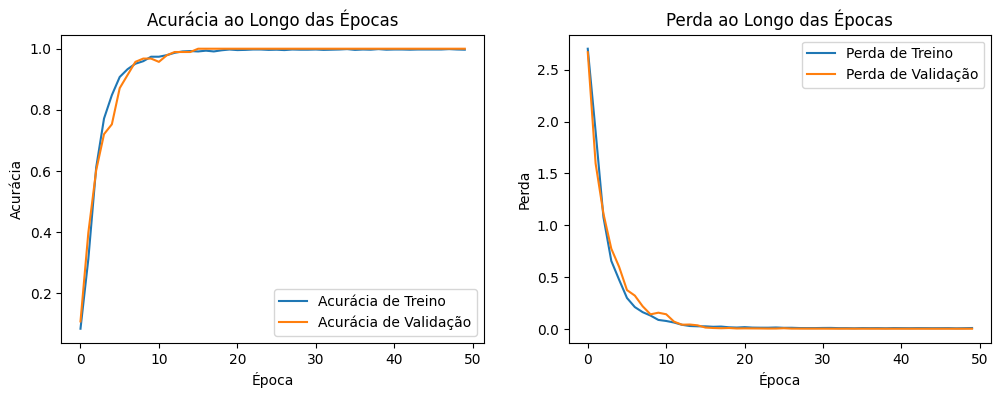

In [11]:
# Plotar o histórico de treinamento
plt.figure(figsize=(12, 4))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.show()

### 9. Função para Predição

Criamos uma função auxiliar para encapsular todo o processo de pré-processamento e predição para uma nova frase.

In [12]:
def predict_service(text):
    # Pré-processar o texto de entrada
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Fazer a predição
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction)

    # Decodificar o resultado para o nome do serviço
    predicted_service_name = label_encoder.inverse_transform([predicted_class_index])

    return predicted_service_name[0]

### 10. Teste do Modelo com Novas Frases

In [13]:
# Save the model
model.save('service_intent_model_8.h5')

### 11. Geração de Dados Sintéticos (Opcional)

Para aumentar a robustez do modelo, podemos gerar dados sintéticos. A célula abaixo cria um novo arquivo CSV com 100 exemplos de frases para cada categoria de serviço, totalizando 1600 novas amostras.

**Atenção**: Execute esta célula apenas uma vez para criar o arquivo.